In [1]:
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
import sklearn
from sentence_transformers import SentenceTransformer, InputExample, losses, util

ModuleNotFoundError: No module named 'sentence_transformers'

In [2]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()


(array([593., 189., 113., 139.,  75.,  97., 111.,  71.,  91., 197.]),
 array([0.25 , 0.325, 0.4  , 0.475, 0.55 , 0.625, 0.7  , 0.775, 0.85 ,
        0.925, 1.   ]),
 <a list of 10 Patch objects>)

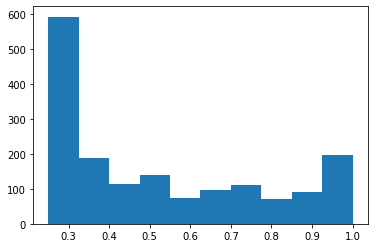

In [3]:
plt.hist((5 - leanDf["ground_truth"]) / 4)

In [4]:
leanDf["ground_truth"] = (5 - leanDf["ground_truth"]) / 4

In [5]:
print(df.shape)
print(len(df["link1"].unique()))
print(len(df["link2"].unique()))

(1690, 20)
1684
1510


In [6]:
deviceNum = 4
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [7]:
#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

,ground_truth,text1,text2
0,0.666667,State Department spokeswoman Morgan Ortagus in...,Iraqi militiamen were back at it again today o...
1,0.375000,Nearly new home in Kerrisdale Estate is availa...,Police have confirmed that a woman has died an...


In [8]:
print("Train Rows: " + str(trainDf.shape[0]))
print("Validation Rows: "  + str(validDf.shape[0]))

Train Rows: 1257
Validation Rows: 419


In [9]:
trainExamples = []
count = 1
for row in trainDf.itertuples(): 
    trainExamples.append(InputExample(texts =[row[2], row[3]], label=row[1]))


In [10]:
#Define the model. Either from scratch of by loading a pre-trained model
#del model 
torch.cuda.empty_cache()

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = torch.utils.data.DataLoader(trainExamples, shuffle=True, batch_size=5)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["ground_truth"]))

check_mem()

#Tune the model
output_path = "/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
checkpoint_path = "/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockTraining"
evaluation_steps = 50
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

In [11]:
evalData = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval/eval/similarity_evaluation_results.csv")

In [12]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,50,0.841091,0.796527,0.863966,0.796527,0.861472,0.796008,0.841091,0.796527
1,0,100,0.863863,0.807143,0.878307,0.807143,0.875159,0.805966,0.863863,0.807143
2,0,150,0.873396,0.809946,0.881485,0.809946,0.878204,0.808379,0.873396,0.809946
3,0,200,0.875530,0.817184,0.881247,0.817184,0.878141,0.812350,0.875530,0.817184
4,0,250,0.878940,0.815434,0.885683,0.815434,0.883276,0.812667,0.878940,0.815434
5,0,-1,0.878837,0.816000,0.885642,0.816000,0.883224,0.812661,0.878837,0.816000
6,1,50,0.881988,0.821326,0.889907,0.821326,0.887613,0.818570,0.881988,0.821326
7,1,100,0.881973,0.820071,0.889399,0.820071,0.886984,0.817858,0.881973,0.820071
8,1,150,0.878949,0.816791,0.886189,0.816791,0.883465,0.812717,0.878949,0.816791
9,1,200,0.881380,0.820545,0.889356,0.820545,0.886719,0.817772,0.881380,0.820545


In [13]:
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
evaluation_steps = 50 
totalSteps = []
for i in range(len(plotData)):
    totalSteps.append(currStep)
    currStep += evaluation_steps 
    
plotData["totalSteps"] = totalSteps

<ipython-input-13-97c093916601>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


In [14]:
plotData["totalSteps"] / 252

0     0.000000
1     0.198413
2     0.396825
3     0.595238
4     0.793651
6     0.992063
7     1.190476
8     1.388889
9     1.587302
10    1.785714
12    1.984127
13    2.182540
14    2.380952
15    2.579365
16    2.777778
Name: totalSteps, dtype: float64

In [15]:
plotData.iloc[23:,:]

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman,totalSteps


Text(0, 0.5, 'Pearson Correlation')

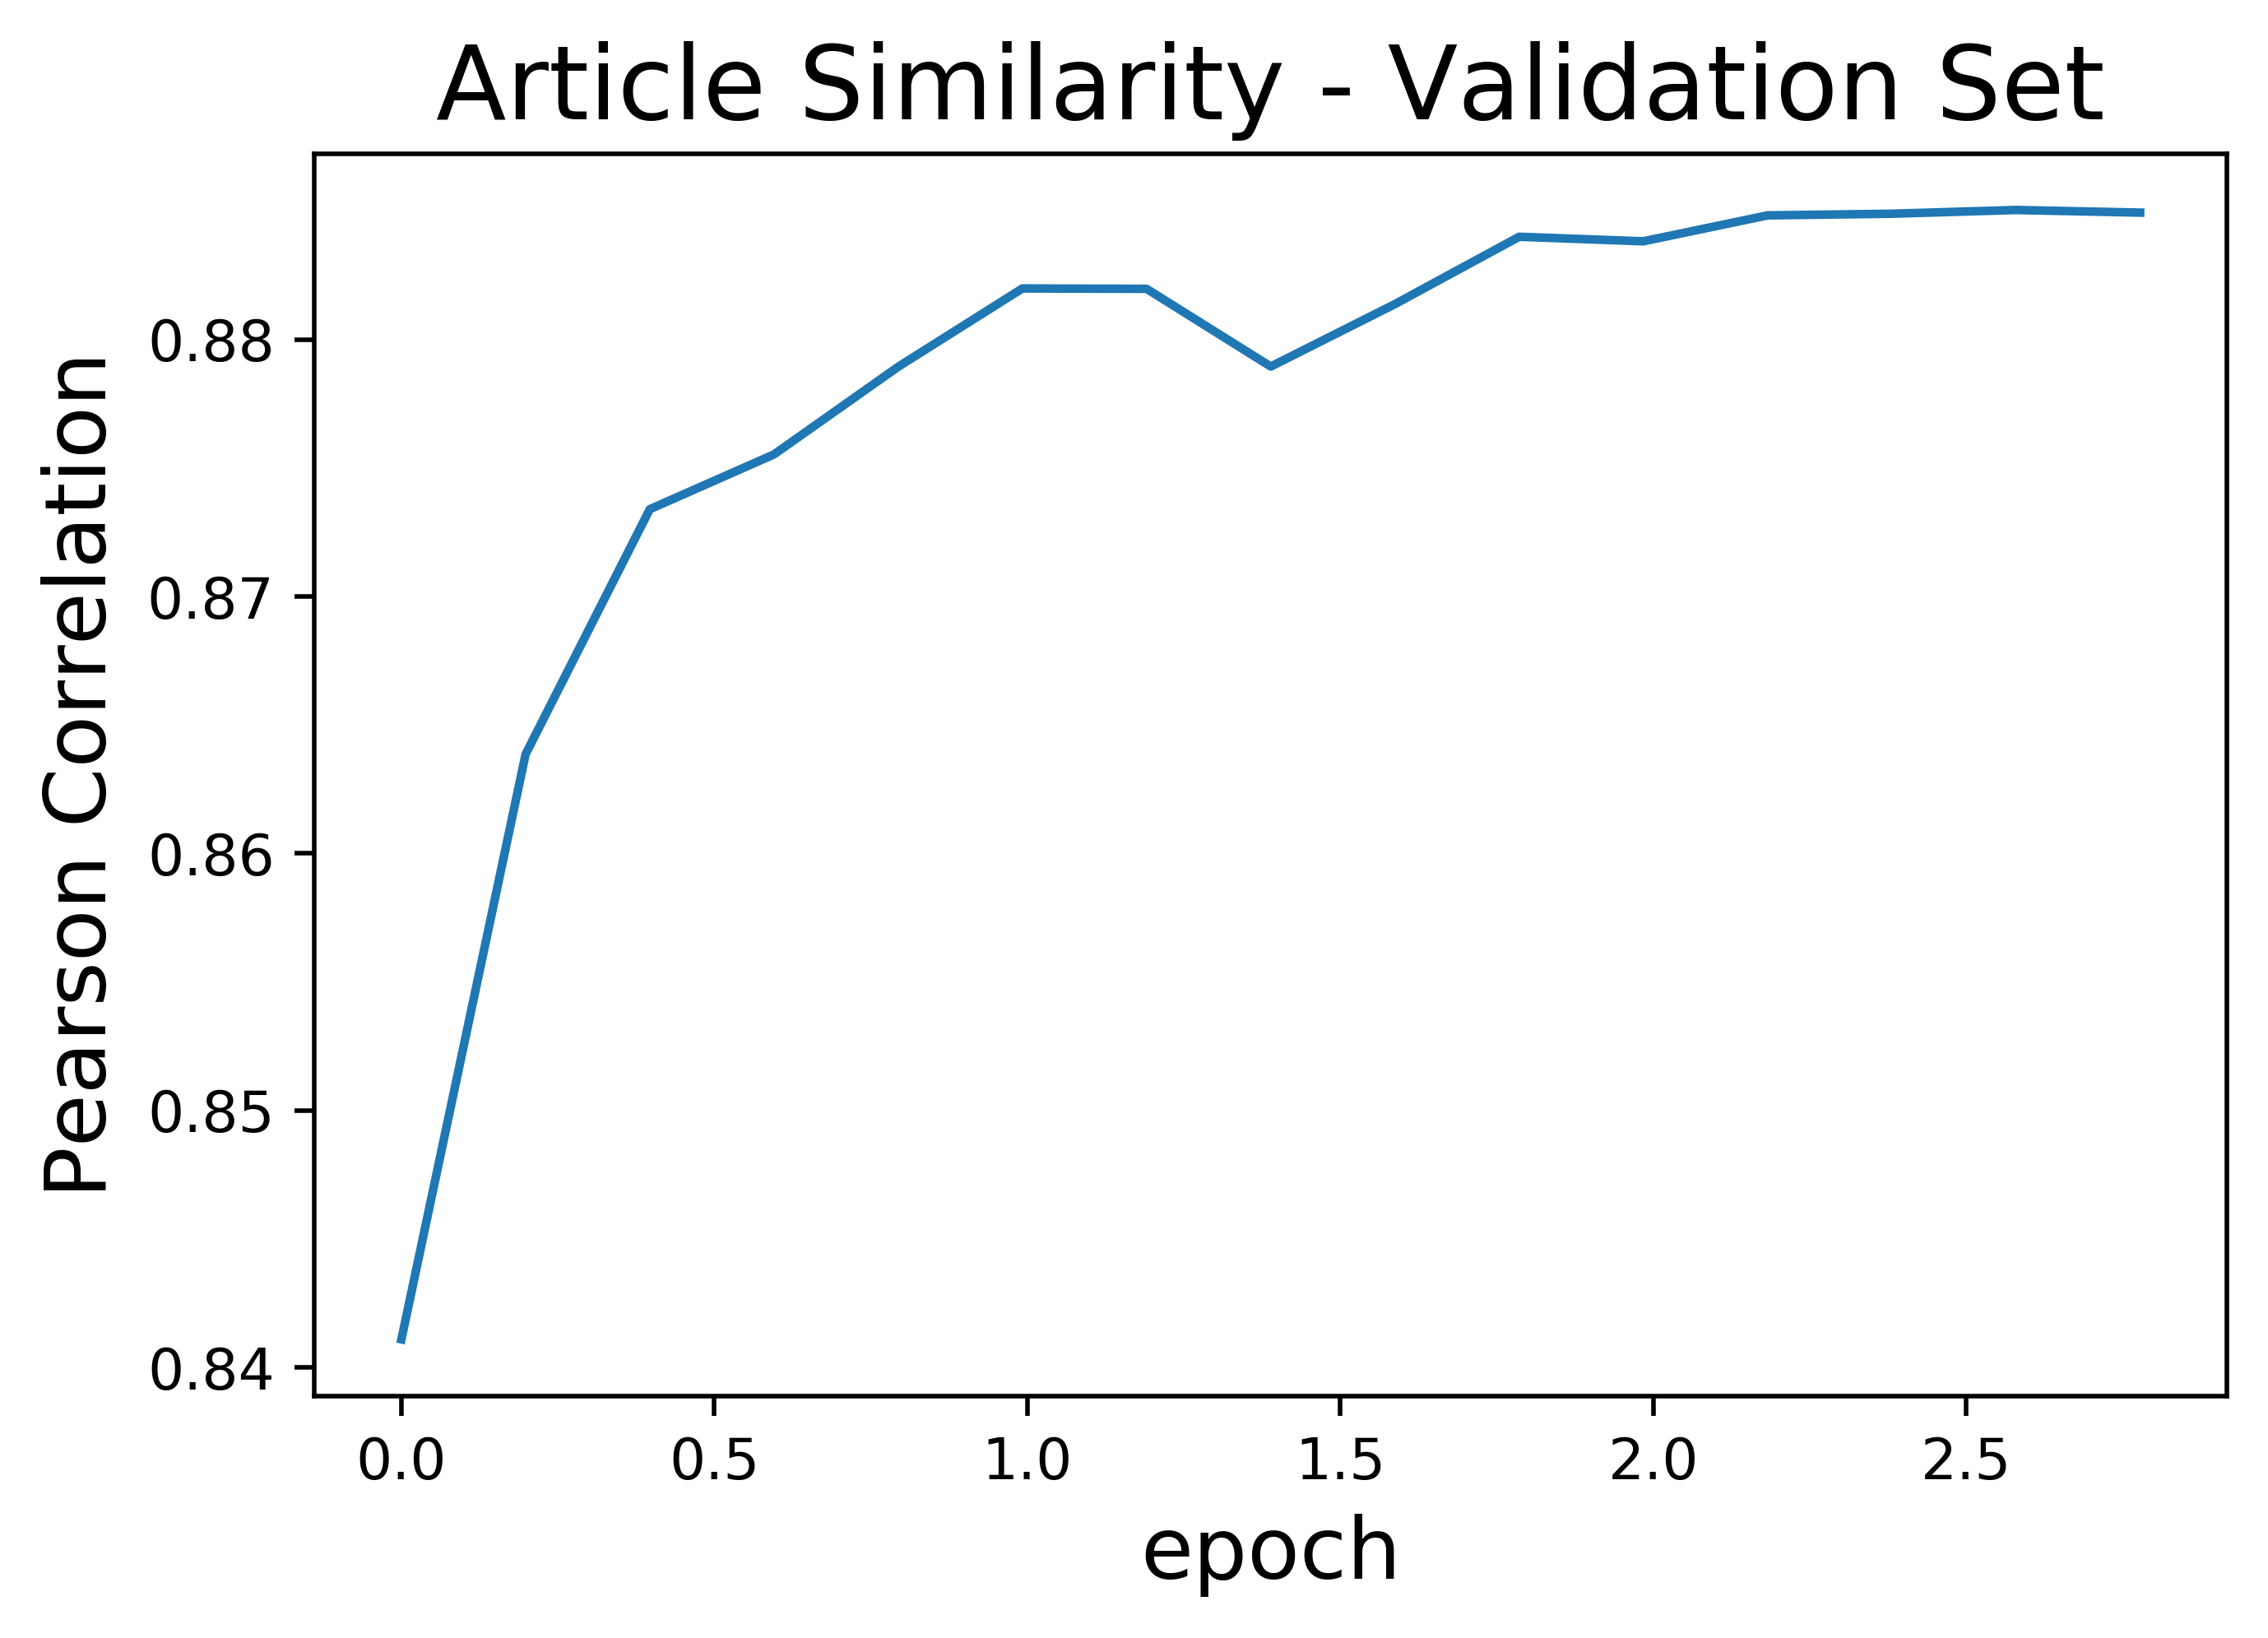

In [16]:
plt.rcParams['figure.dpi'] = 500
plt.plot(plotData["totalSteps"] / 252, plotData["cosine_pearson"])
plt.title("Article Similarity - Validation Set", size=18)
plt.xlabel("epoch", size=15)
plt.ylabel("Pearson Correlation", size=15)

In [17]:


testRow = validDf.reset_index(drop=True).iloc[0,:]
testExample = InputExample(texts = [testRow[1], testRow[2]], label=testRow[0])


In [39]:
testDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTestData.csv", sep="\t")
testDf.head(1)

,Unnamed: 0,url1_lang,url2_lang,pair_id,link1,link2,ia_link1,ia_link2,GEO,ENT,TIME,NAR,Overall,STYLE,TONE,id1,id2,text1,text2
0,0,en,en,1484189203_1484121193,https://wsvn.com/news/local/broward/police-2-m...,https://wsvn.com/news/local/no-swim-advisory-l...,https://web.archive.org/web/https://wsvn.com/n...,https://web.archive.org/web/https://wsvn.com/n...,1.5,4.0,2.0,4.0,3.5,1.0,1.5,1484189203,1484121193,"DAVIE, FLA. (WSVN) - Police need help catching...","DEERFIELD BEACH, FLA. (WSVN) - A no-swim advis..."


In [40]:
testDf.shape

(234, 19)

In [41]:
#modelPath = "/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
#model = SentenceTransformer(modelPath)

In [42]:
#compute embeddings for the test data and get correlation with ground truth 
text1 = list(testDf["text1"])
text2 = list(testDf["text2"])

embed1 = model.encode(text1)
embed2 = model.encode(text2)

In [43]:
cos_scores = [] 

for i in range(len(embed1)): 
    cos_scores.append(util.cos_sim(embed1[i], embed2[i]))
cos_scores[:2]

[tensor([[0.2221]]), tensor([[0.7609]])]

In [74]:
preds = [float(item) for item in cos_scores]
gt = (5 - testDf["Overall"]) / 4
np.corrcoef([preds, gt])

array([[1.        , 0.75494347],
       [0.75494347, 1.        ]])

In [45]:
comparisonMat = pd.DataFrame({"gt":gt, "preds":preds})

In [68]:
cutoff = .6
comparisonMat["gtIsSame"] = comparisonMat["gt"] >= .9
comparisonMat["gtIsSame"] = comparisonMat["gtIsSame"].astype(int)

comparisonMat["predIsSame"] = comparisonMat["preds"] >= .9
comparisonMat["predIsSame"] = comparisonMat["predIsSame"].astype(int)
comparisonMat

,gt,preds,gtIsSame,predIsSame
0,0.375,0.222147,0,0
1,1.000,0.760908,1,0
2,0.250,0.263818,0,0
3,0.875,0.816687,0,0
4,0.250,0.308660,0,0
...,...,...,...,...
229,0.250,0.260957,0,0
230,1.000,0.827563,1,0
231,0.750,0.772603,0,0
232,0.750,0.797966,0,0


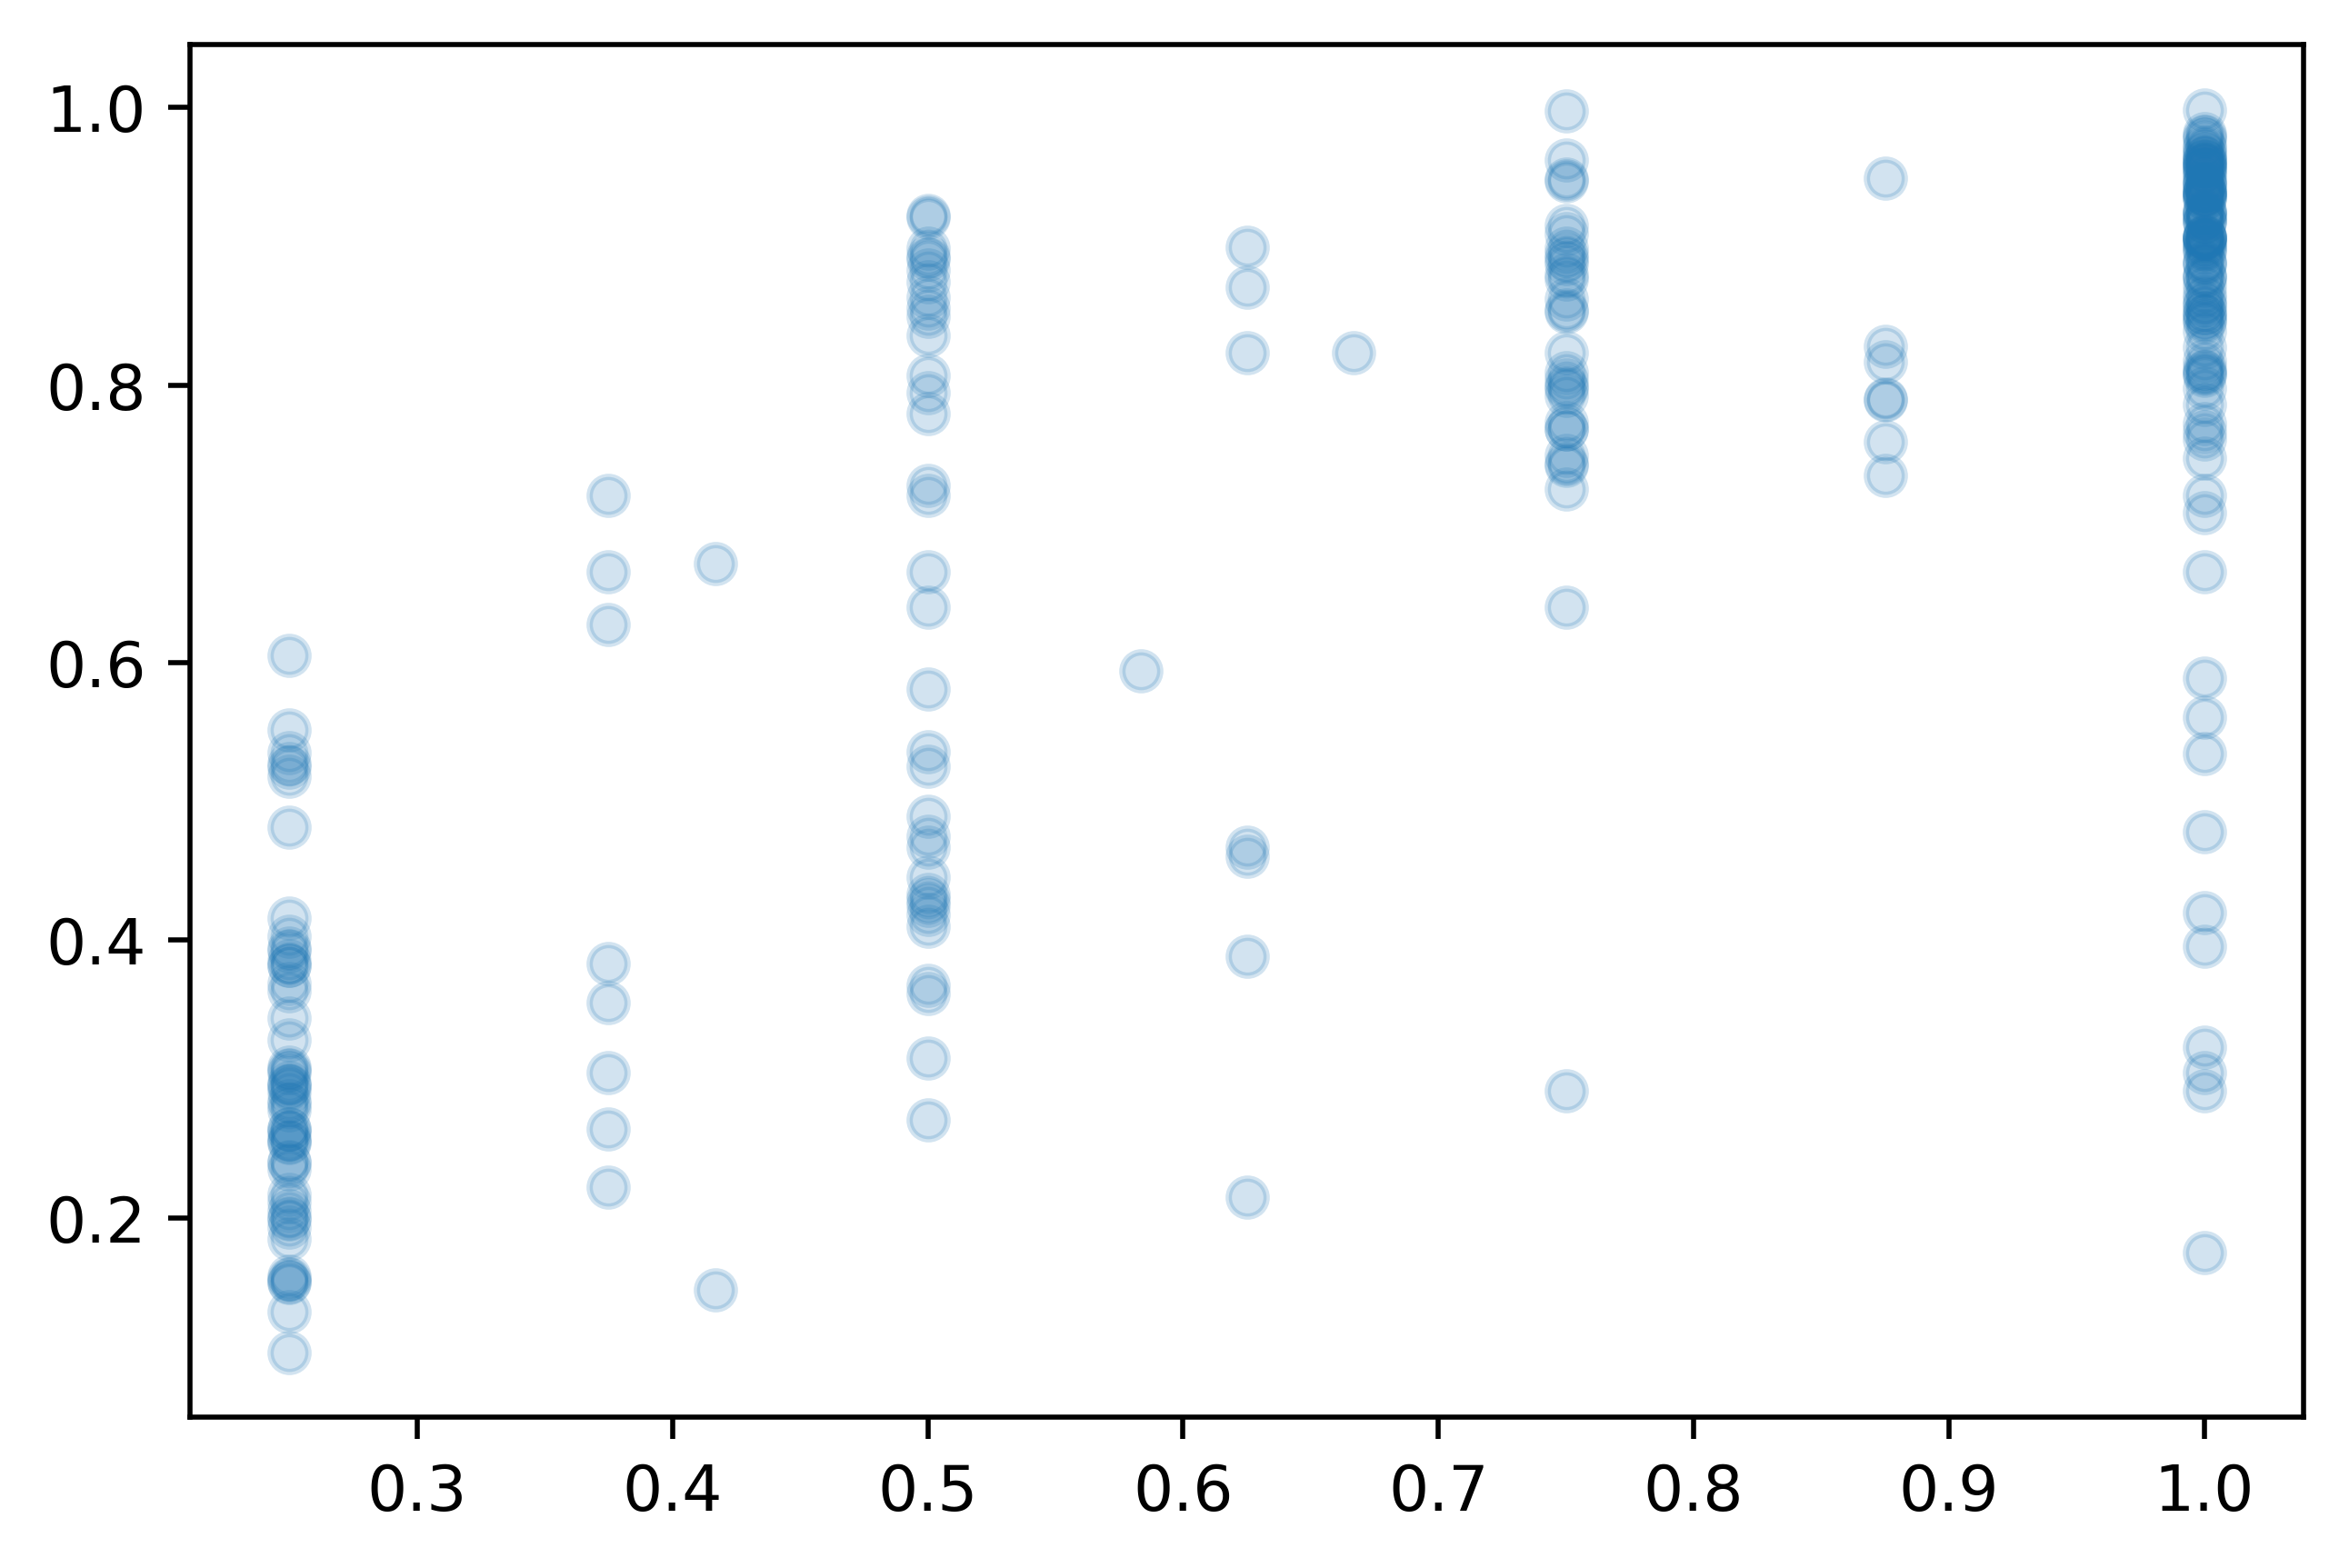

In [83]:
#compare ground truth on x axis to predictions on the y 
plt.scatter(comparisonMat["gt"], comparisonMat["preds"], alpha = .2)


Text(0, 0.5, 'Count')

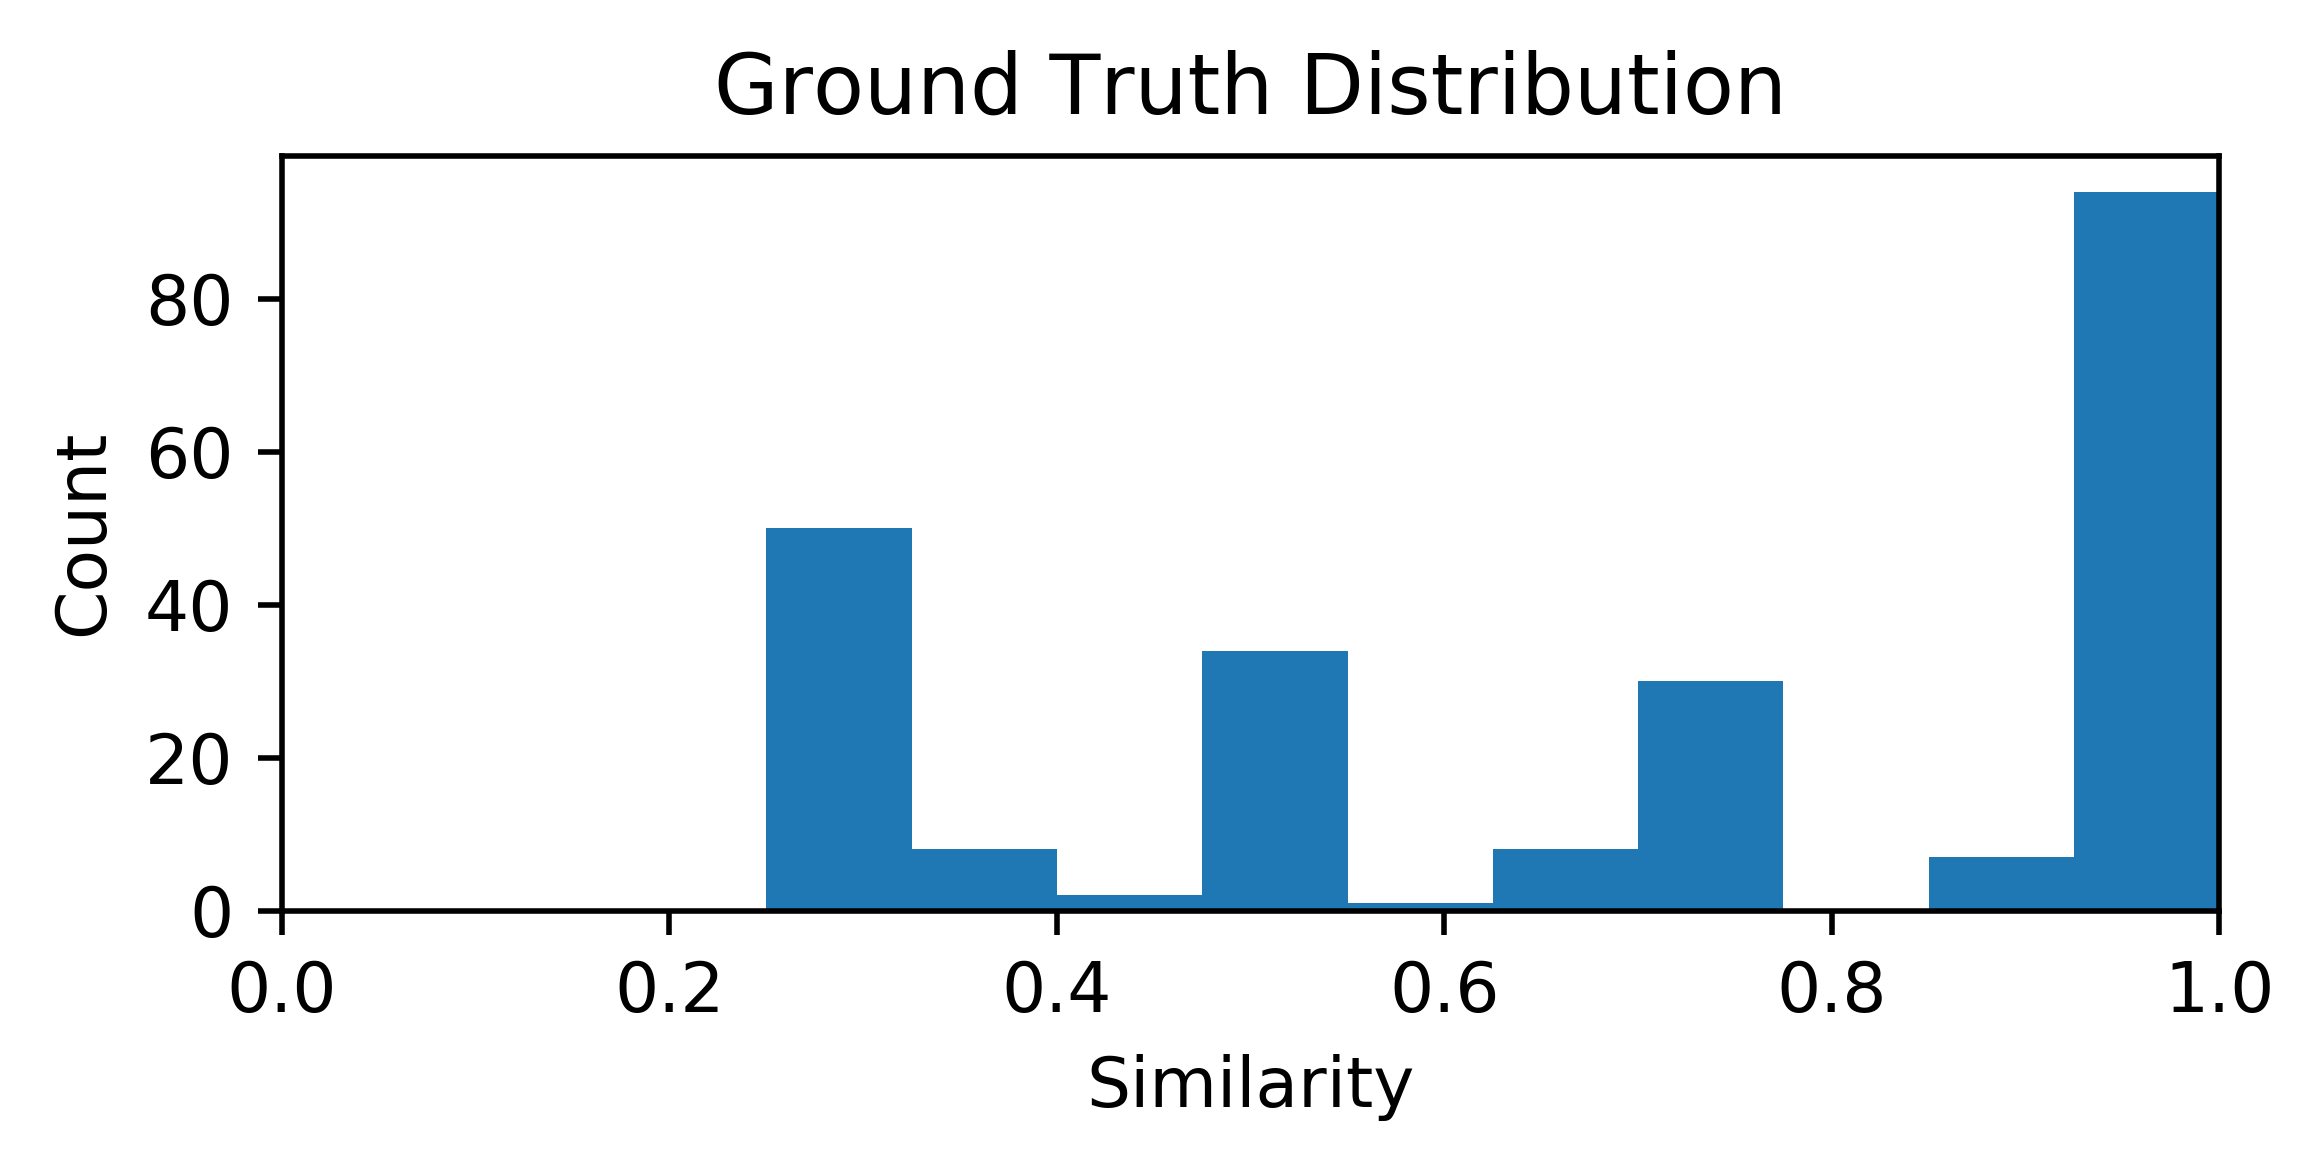

In [70]:
fig, ax = plt.subplots(figsize=[5, 2])
plt.hist(comparisonMat["gt"])
plt.title("Ground Truth Distribution")
plt.xlim([0, 1])
plt.xlabel("Similarity")
plt.ylabel("Count")

In [71]:
conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])
conf

array([[131,   9],
       [ 45,  49]])

In [72]:
acc = (conf[0,0] + conf[1, 1] ) / (len(comparisonMat))
tn, fp, fn, tp = conf.ravel()

In [73]:
precision = (tp) / (tp + fp)
print("precision: " + str(precision))
recall = (tp) / (tp + fn)
print("recall: " + str(recall))

precision: 0.8448275862068966
recall: 0.5212765957446809


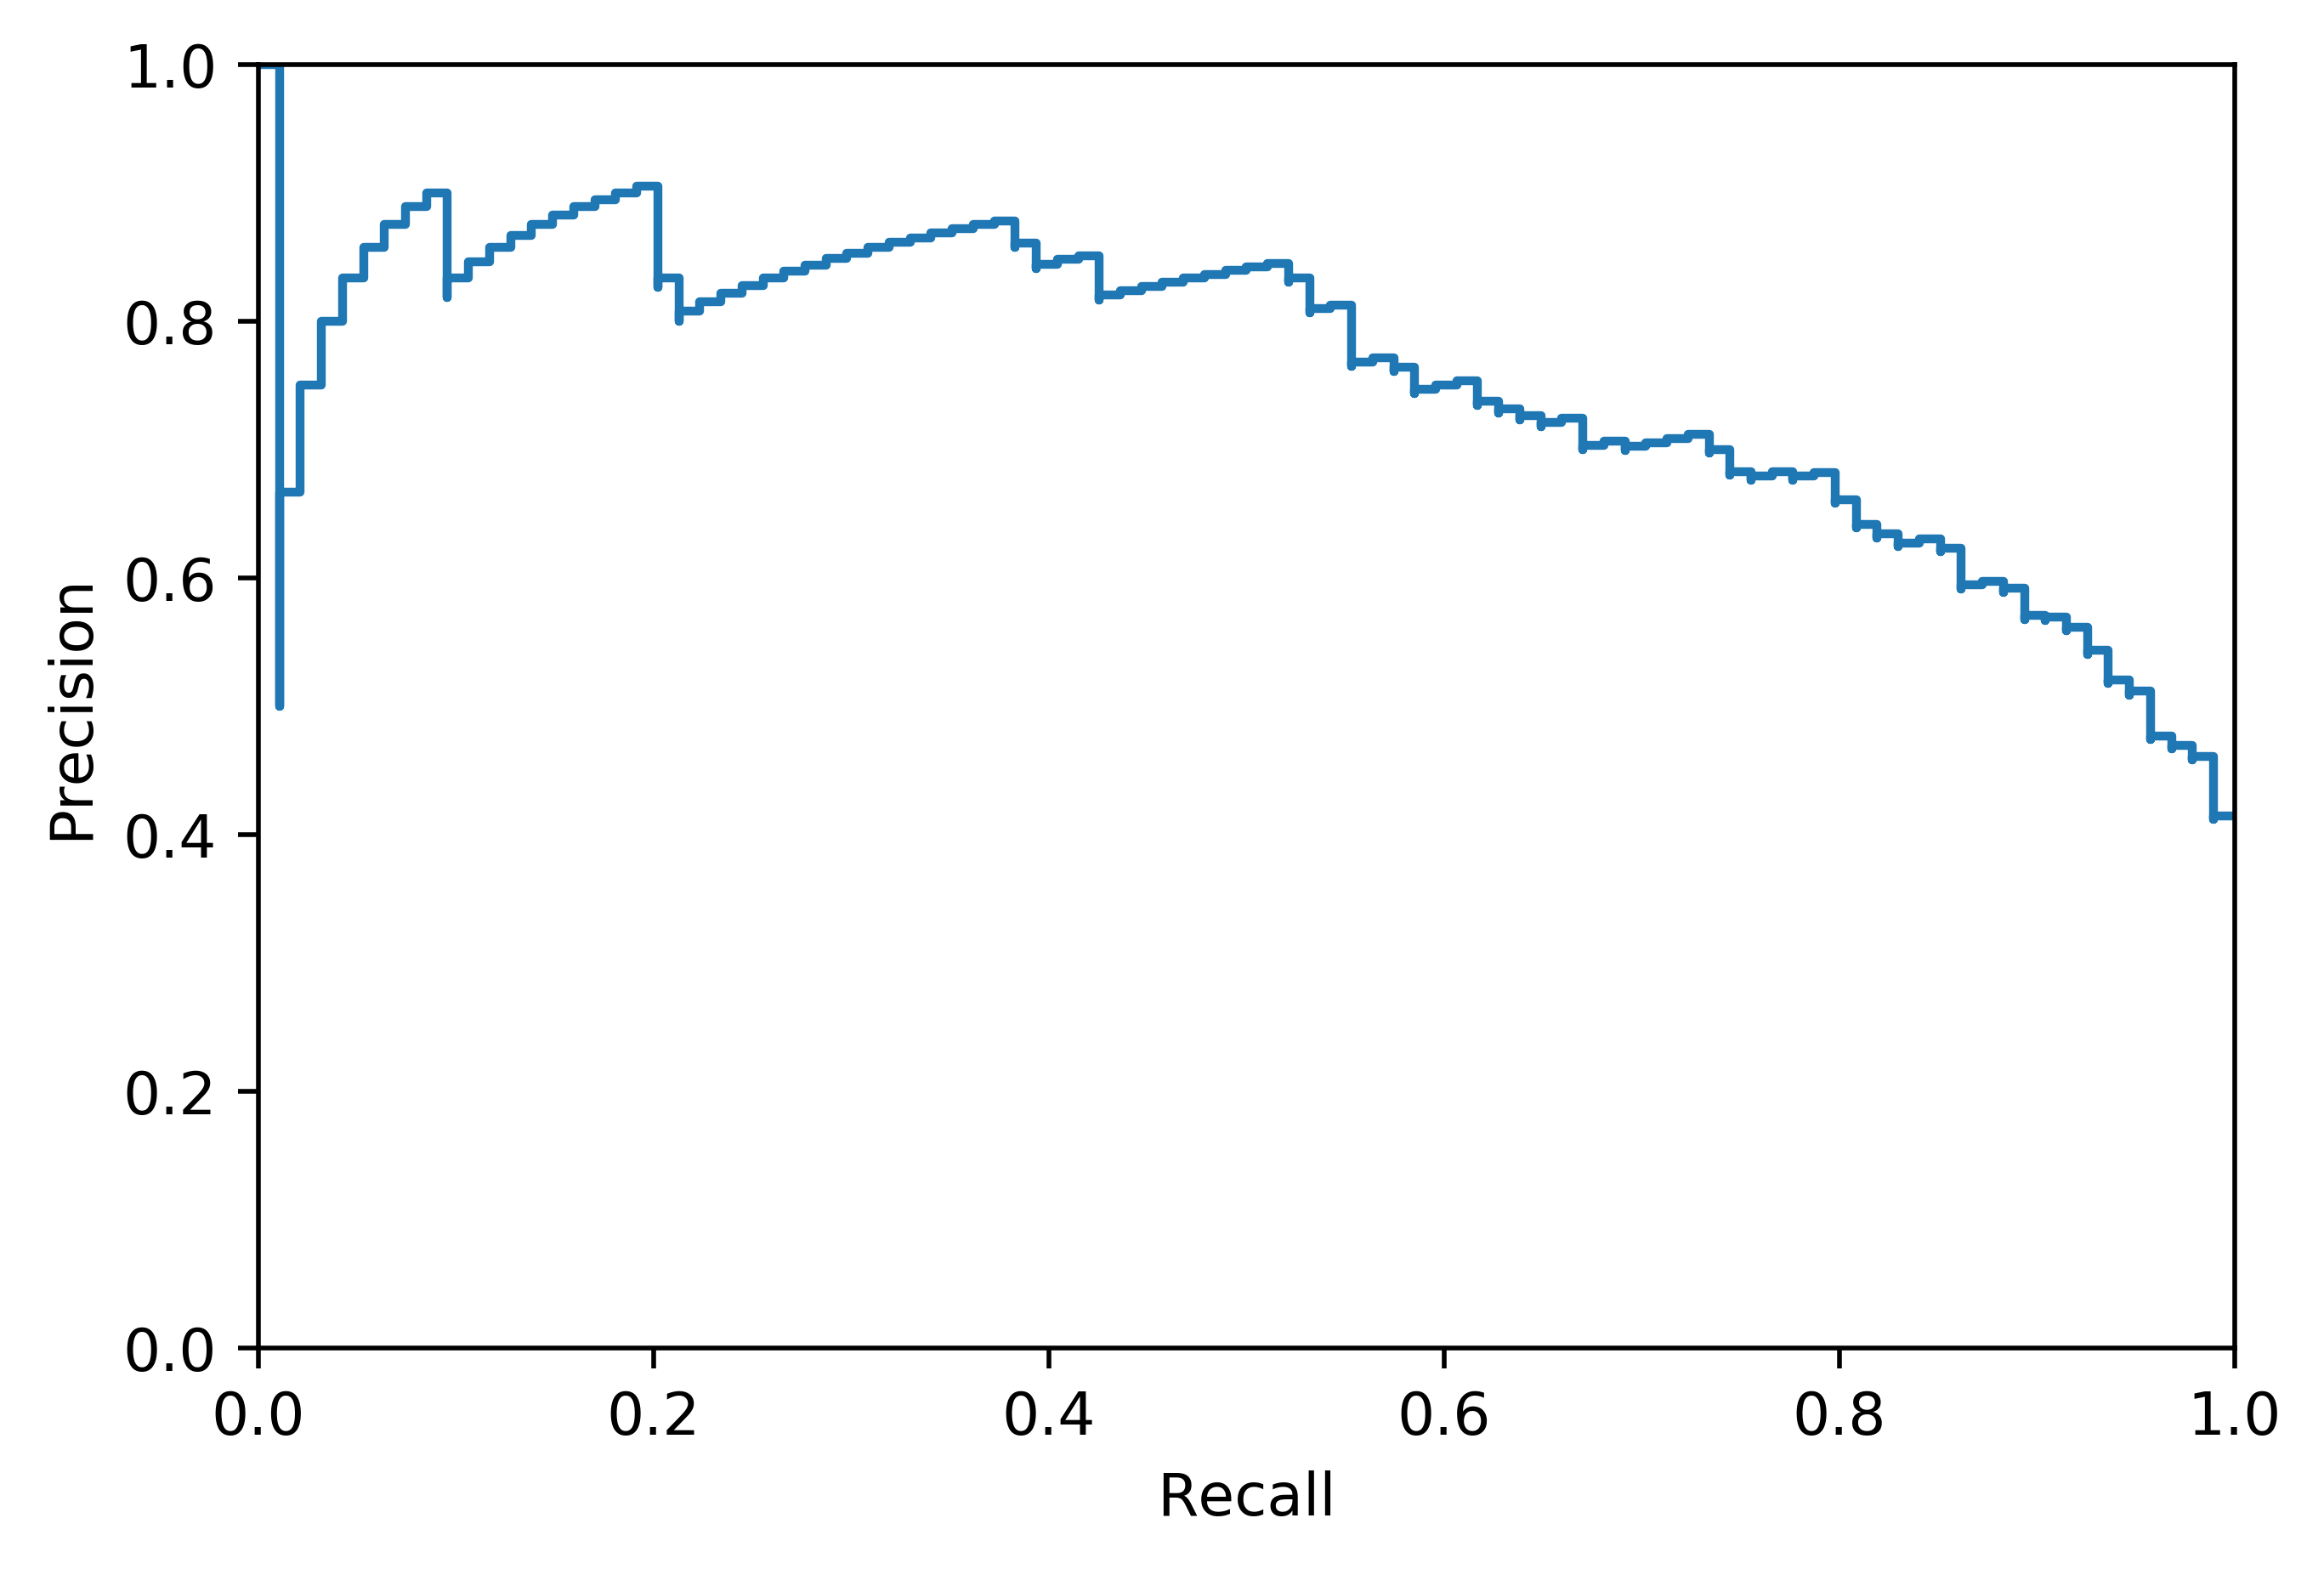

In [82]:
#an interesting plot. If we call anything greater than .9 similar then we can find an optimal cutoff for our prediction. 
#although we should really just use the same one intuitively... 
precision, recall, _ = sklearn.metrics.precision_recall_curve(comparisonMat["gtIsSame"], comparisonMat["preds"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()